# `pyrealsense` jupyter example

In [87]:
import pyrealsense as pyrs
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import NoNorm
%matplotlib inline

import cv2
import time

In [88]:
# Enumerate all available devices:
with pyrs.Service() as serv:
    for dev in serv.get_devices():
        print(dev)

{'is_streaming': 0, 'firmware': '1.0.72.06', 'serial': '2441006710', 'id': 0, 'name': 'Intel RealSense R200'}


## Accessing Color Streams

In [89]:
# Define simple function that uses `matplotlib` to visualize a given frame and its channels separately:
def show_rgb_frame(frame, labels='RGB'):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(frame, aspect='auto', norm=NoNorm())
    plt.title(labels)
    plt.xticks([])
    plt.yticks([])

    for chn in range(3):
        plt.subplot(1, 4, chn+2)
        plt.imshow(frame[:, :, chn], aspect='auto', norm=NoNorm())
        plt.title(labels[chn])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    
def show_yuv_frame(frame):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 4, 1)
    conv = cv2.cvtColor(frame, cv2.COLOR_YUV2RGB_YUYV)
    plt.imshow(conv, aspect='auto', norm=NoNorm())
    plt.title('YUV')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 2)
    plt.imshow(frame[:, :, 0], aspect='auto', norm=NoNorm())
    plt.title('Y')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 4, 3)
    plt.imshow(frame[::2, ::2, 1], aspect='auto', norm=NoNorm())
    plt.title('U')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 4)
    plt.imshow(frame[1::2, 1::2, 1], aspect='auto', norm=NoNorm())
    plt.title('V')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [90]:
def plot_color_frame(color_format='rgb', n_frames=1, wait=1.):
    # Initialize service
    with pyrs.Service() as serv:
        color_stream = pyrs.stream.ColorStream(color_format=color_format)
        # Initialize device
        with serv.Device(streams=(color_stream,)) as dev:
            time.sleep(wait)
            dev.wait_for_frames()
            for _ in range(n_frames):
                frame = dev.color  # Access image buffer
                if color_format != 'yuv':
                    show_rgb_frame(frame, labels=color_format.upper())
                else:
                    show_yuv_frame(frame)
                dev.wait_for_frames()  # Wait for the first frame

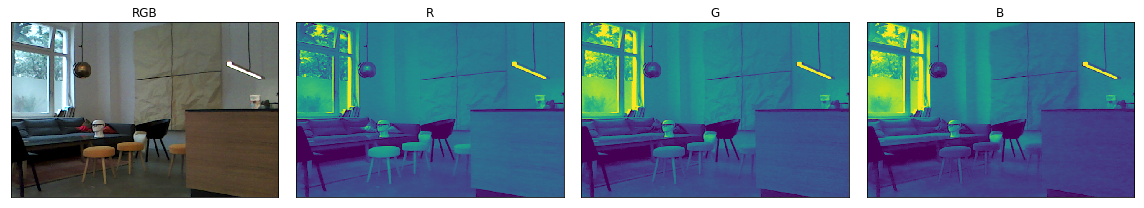

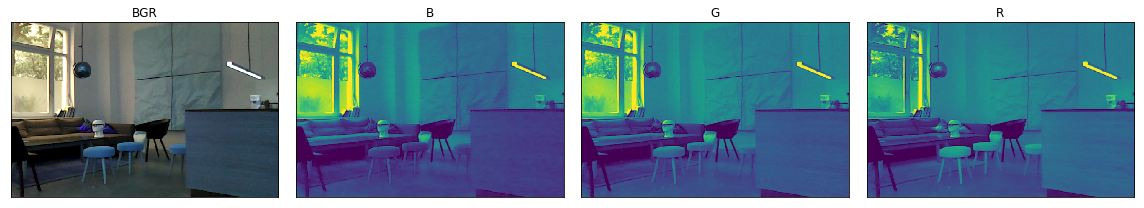

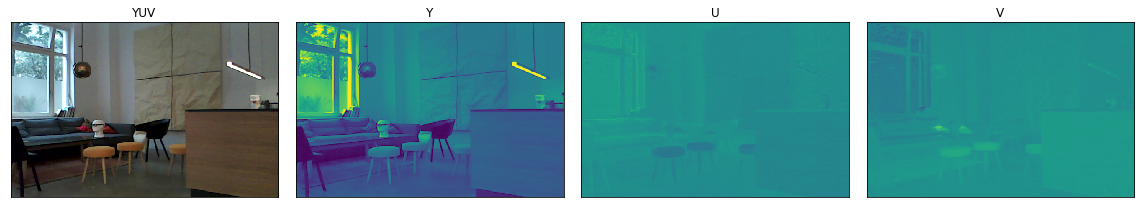

In [113]:
for fmt in ('rgb', 'bgr', 'yuv'):
    plot_color_frame(fmt)

## Accessing Depth Streams

In [152]:
def convert_z16_to_rgb(frame):
    
    # calculate depth histogram
    hist, edges = np.histogram(frame, bins=0x10000)
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(edges[:-1], hist, s=1)
    plt.title('Depth histogram')
    
    # calculate cumulative depth histogram
    hist = np.cumsum(hist)
    hist -= hist[0]
    plt.subplot(1, 2, 2)
    plt.scatter(edges[:-1], hist, s=1)
    plt.title('Cumulative depth histogram')
    plt.tight_layout()
    rgb_frame = np.zeros(frame.shape[:2] + (3,), dtype=np.uint8)
    
    zeros = frame==0
    non_zeros = frame!=0
    
    f = hist[frame[non_zeros]] * 255 / hist[0xFFFF]
    rgb_frame[non_zeros, 0] = f
    rgb_frame[non_zeros, 1] = 0
    rgb_frame[non_zeros, 2] = 255 - f
    rgb_frame[zeros, 0] = 0
    rgb_frame[zeros, 1] = 5
    rgb_frame[zeros, 2] = 20
    return rgb_frame

def plot_depth_frame(n_frames=1, wait=1.):
    # Initialize service
    with pyrs.Service() as serv:
        depth_stream = pyrs.stream.DepthStream()
        # Initialize device
        with serv.Device(streams=(depth_stream,)) as dev:
            time.sleep(wait)
            dev.wait_for_frames()
            for _ in range(n_frames):
                frame = dev.depth  # Access image buffer
                frame = convert_z16_to_rgb(frame)
                plt.figure(figsize=(16, 12))
                plt.imshow(frame, aspect='auto', norm=NoNorm())
                plt.xticks([])
                plt.yticks([])


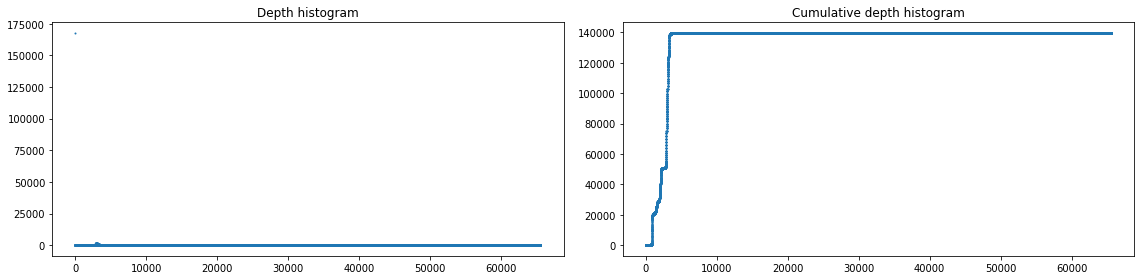

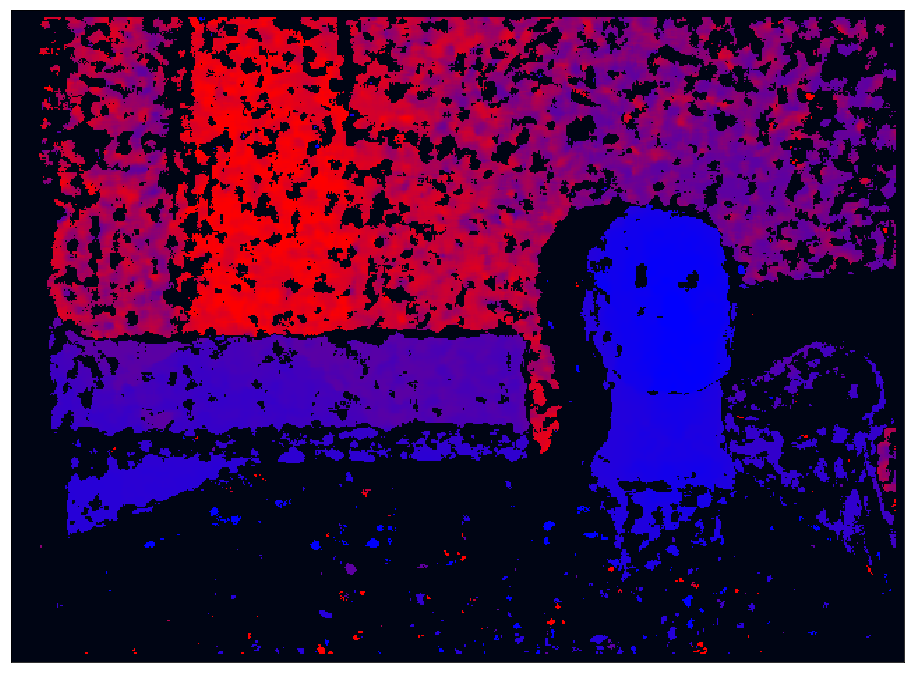

In [154]:
plot_depth_frame()